## Purpose of module

This module uses the technique described in 'Online short-term solar forecasting' by Bacher P, Madsen H & Nielsen HA (2009) to normalise the mean direct horizontal radiation by dividing by a clear sky model, created by smoothing the data in two dimensions; day of the year and hour of the day. 

## Import modules, load and transform data

In [12]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.optimize import minimize
from scipy.spatial import distance
import numpy as np
import os
import pandas as pd
import patsy
import pytz
#import pyephem
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

%matplotlib inline

In [13]:
PV_2017 = pd.read_csv('..//solar_data/PV_2017.csv',parse_dates=['date_time'],index_col='date_time')

# The timestamp in the input data is set to UTC but Pandas strips the time zone information when parsing.
# The following operation first creates 'time zone aware' timestamps, then localises it to Adelaide time.
PV_2017.index = PV_2017.index.tz_localize('UTC').tz_convert('Australia/Adelaide')

In [14]:
PV_2017.columns

Index(['record_id', 'station_number', 'mean_global', 'min_global',
       'max_global', 'sd_global', 'uncert_mean_global', 'mean_direct',
       'min_direct', 'max_direct', 'sd_direct', 'uncert_mean_direct',
       'mean_diffuse', 'min_diffuse', 'max_diffuse', 'sd_diffuse',
       'uncert_mean_diffuse', 'mean_terr', 'min_terr', 'max_terr', 'sd_terr',
       'uncert_mean_terr', 'mean_dir_horiz', 'min_dir_horiz', 'max_dir_horiz',
       'sd_dir_horiz', 'uncert_dir_horiz', 'sunsh_sec_96', 'sunsh_sec_120',
       'sunsh_sec_144', 'zenith_dist'],
      dtype='object')

In [15]:
use_cols = ['mean_dir_horiz','mean_diffuse'] # Assuming this is the same as Global Horizontal Irradiance (GHI)
PV_2017 = PV_2017[use_cols]

In [16]:
PV_2017.head()

,mean_dir_horiz,mean_diffuse
date_time,,
2017-01-01 00:00:00+10:30,0.0,0.0
2017-01-01 00:01:00+10:30,0.0,0.0
2017-01-01 00:02:00+10:30,0.0,0.0
2017-01-01 00:03:00+10:30,0.0,0.0
2017-01-01 00:04:00+10:30,0.0,0.0


In [17]:
PV_2017['GHI'] = PV_2017.mean_dir_horiz + PV_2017.mean_diffuse

In [19]:
# Confirm that the index is a time zone aware datetime object - return first and last objects
[PV_2017.iloc[0].name,PV_2017.iloc[-1].name]

[Timestamp('2017-01-01 00:00:00+1030', tz='Australia/Adelaide'),
 Timestamp('2017-12-31 23:59:00+1030', tz='Australia/Adelaide')]

Create new variables;

 * Time of day
 * Day of year

In [20]:
# Add time of day (in minutes from midnight at the start of each day)
PV_2017['time_of_day'] = PV_2017.index.map(lambda x: (
    x.combine(x.date(),x.time()) - x.combine(x.date(),dt.time(0,0))).seconds / 60 + 1)

In [21]:
# Add day of year beginning 1 January
first_day_of_year = dt.date(2017,1,1)
PV_2017['day_of_year'] = PV_2017.index.map(lambda x: (x.date() - first_day_of_year).days + 1)

In [22]:
winter_solstice = (6,21)

In [23]:
def days_since_winter_solstice(qdate):
    current_years_solstice = dt.date(qdate.year,6,21)
    last_years_solstice = dt.date(qdate.year-1,6,21)
    if qdate < current_years_solstice:
        return (qdate - last_years_solstice).days + 1
    else:
        return (qdate - current_years_solstice).days + 1

PV_2017['days_since_winter_solstice'] = PV_2017.index.map(lambda x: days_since_winter_solstice(x.date()))

In [24]:
dt.date(2018,*winter_solstice)

datetime.date(2018, 6, 21)

Let each year be delimited by winter solstices, so the summer solstice falls in the middle of each year.

Define `summer_solstice_delta` as the distance/delta in days from the summer solstice.

In [25]:
def summer_solstice_delta(qdate):
    last_solstice = dt.date(qdate.year-1,*winter_solstice)
    next_solstice = dt.date(qdate.year,*winter_solstice)
    return
'''    
    if qdate < current_year_solstice:
        return (current_year_solstice - qdate).days + 1
    else:
        return (current_year_solstice - qdate).days + 1
'''
PV_2017['days_to_nearest_summer_solstice'] = PV_2017.index.map(lambda x: days_since_winter_solstice(x.date()))

In [12]:
summer_solstice = dt.date(2017,12,22)
winter_solstice = dt.date(2017,6,21)
PV_2017['summer_solstice_delta'] = PV_2017.index.map(lambda x: (x.date() - summer_solstice).days)
PV_2017['winter_solstice_delta'] = PV_2017.index.map(lambda x: (x.date() - winter_solstice).days)

In [26]:
PV_2017.head()

,mean_dir_horiz,mean_diffuse,GHI,time_of_day,day_of_year,days_since_winter_solstice,days_to_nearest_summer_solstice
date_time,,,,,,,
2017-01-01 00:00:00+10:30,0.0,0.0,0.0,1.0,1,195,195
2017-01-01 00:01:00+10:30,0.0,0.0,0.0,2.0,1,195,195
2017-01-01 00:02:00+10:30,0.0,0.0,0.0,3.0,1,195,195
2017-01-01 00:03:00+10:30,0.0,0.0,0.0,4.0,1,195,195
2017-01-01 00:04:00+10:30,0.0,0.0,0.0,5.0,1,195,195


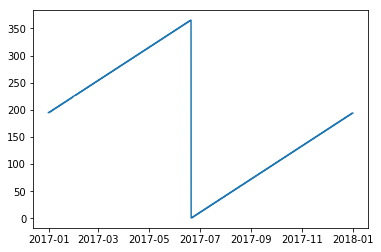

In [14]:
plt.plot(PV_2017.days_to_nearest_summer_solstice);

In [15]:
# There are some missing values in the data
PV_2017.mean_dir_horiz.isnull().values.any()

True

In [16]:
PV_2017[PV_2017.isnull().any(axis=1)].iloc[0]

mean_dir_horiz                   NaN
mean_diffuse                   232.5
GHI                              NaN
time_of_day                   1005.0
day_of_year                      7.0
days_since_winter_solstice     201.0
summer_solstice_delta         -349.0
winter_solstice_delta         -165.0
Name: 2017-01-07 16:44:00+10:30, dtype: float64

In [17]:
# Replace all missing values with zero
#PV_2017 = PV_2017.fillna(0)

# Should this be the last observed point, or straight line between last observed and next observed? 

In [18]:
# Resample from minute frequency to 15 minute frequency to speed up calculation times
PV_2017_15M = PV_2017.resample('15T').mean()

In [19]:
PV_2017_15M.head()

,mean_dir_horiz,mean_diffuse,GHI,time_of_day,day_of_year,days_since_winter_solstice,summer_solstice_delta,winter_solstice_delta
date_time,,,,,,,,
2017-01-01 00:00:00+10:30,0.0,0.0,0.0,8.0,1.0,195.0,-355.0,-171.0
2017-01-01 00:15:00+10:30,0.0,0.0,0.0,23.0,1.0,195.0,-355.0,-171.0
2017-01-01 00:30:00+10:30,0.0,0.0,0.0,38.0,1.0,195.0,-355.0,-171.0
2017-01-01 00:45:00+10:30,0.0,0.0,0.0,53.0,1.0,195.0,-355.0,-171.0
2017-01-01 01:00:00+10:30,0.0,0.0,0.0,68.0,1.0,195.0,-355.0,-171.0


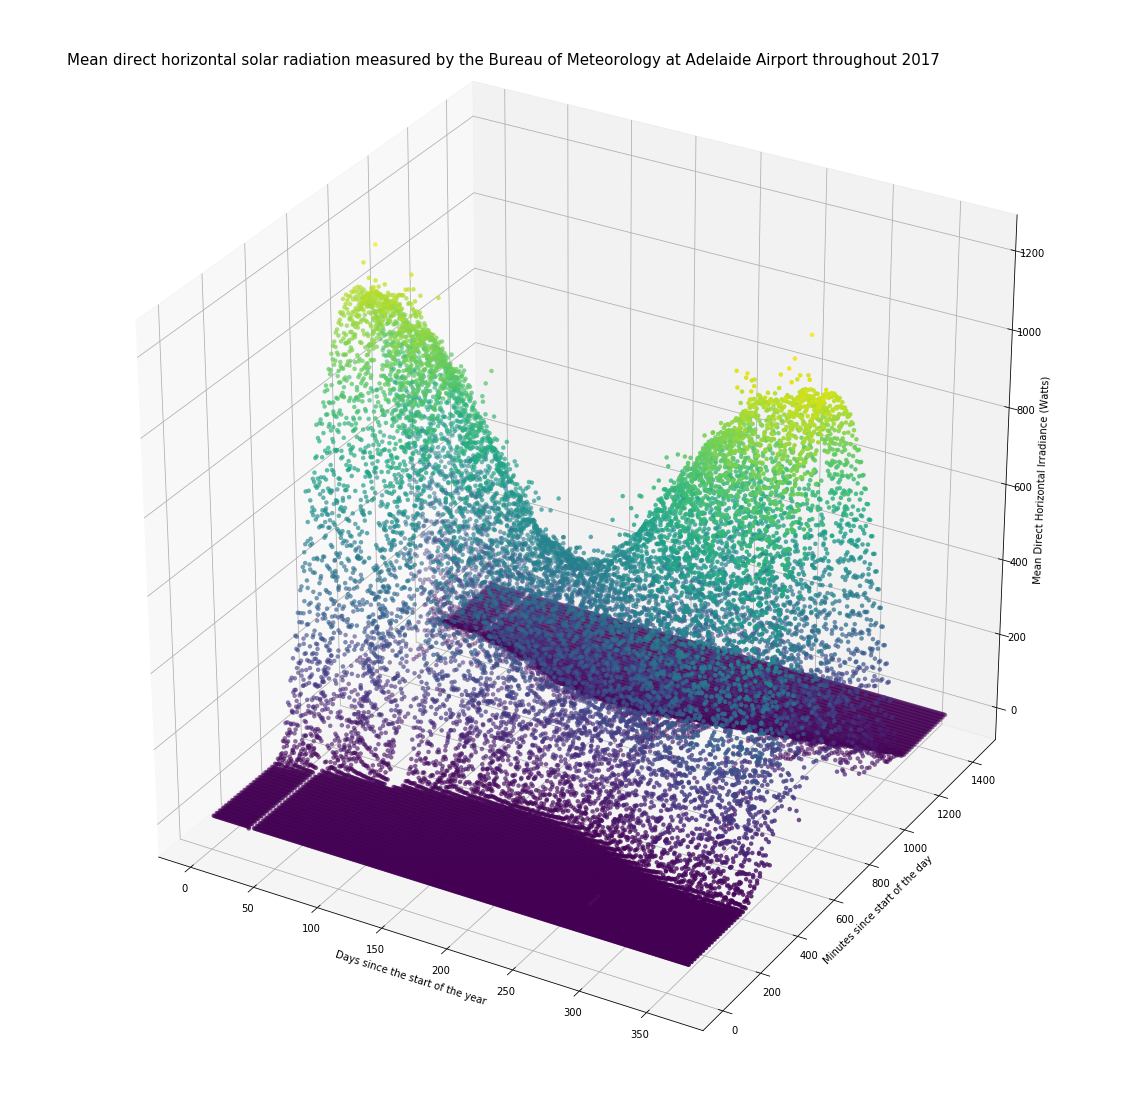

In [20]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_2017_15M.day_of_year, PV_2017_15M.time_of_day, PV_2017_15M.GHI, 
                c=PV_2017_15M.GHI, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days since the start of the year')
ax.set_ylabel('Minutes since start of the day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

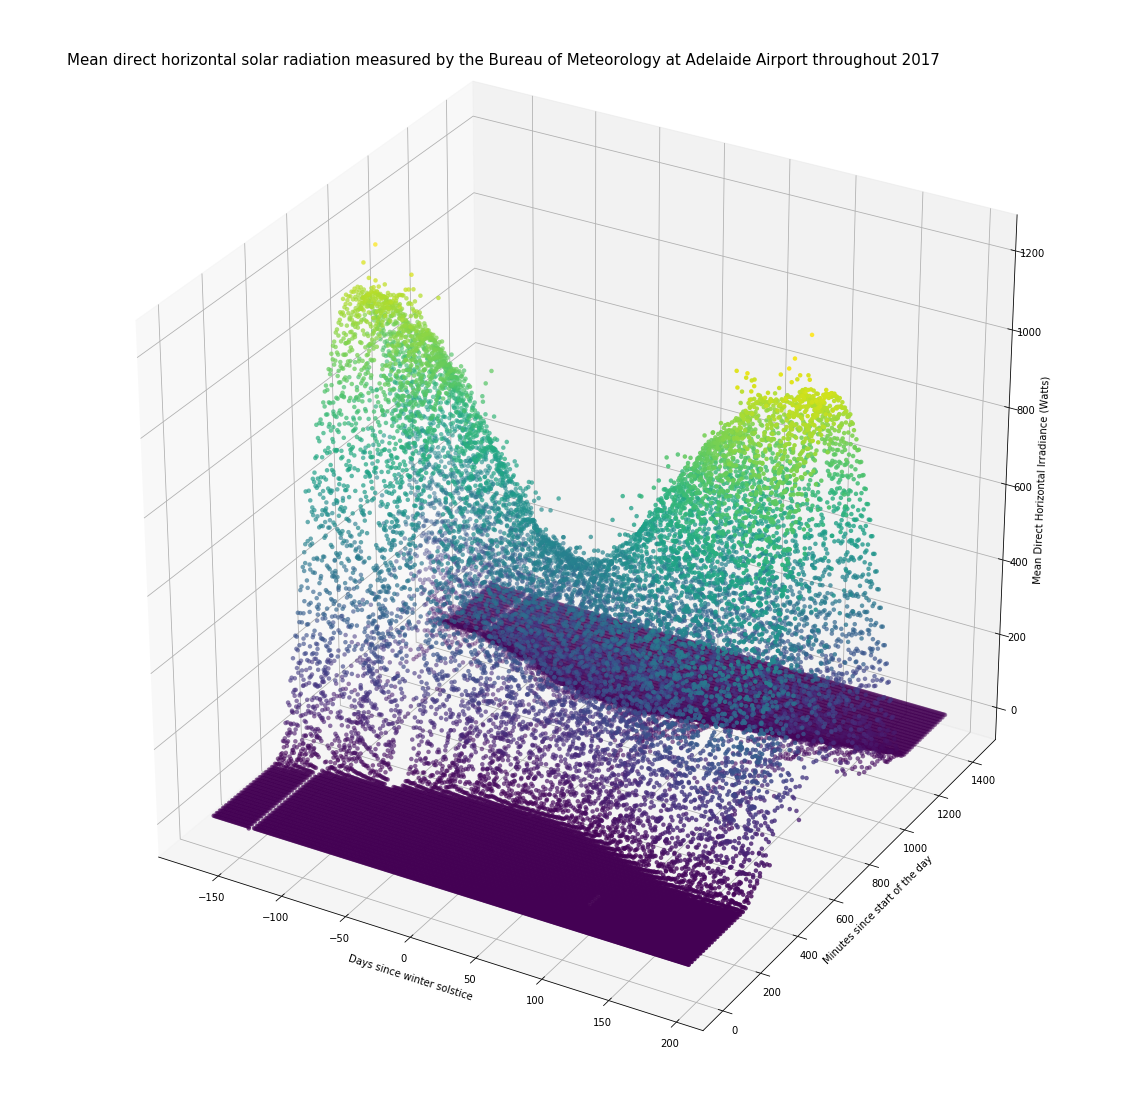

In [21]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_2017_15M.winter_solstice_delta, PV_2017_15M.time_of_day, PV_2017_15M.GHI, 
                c=PV_2017_15M.GHI, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days since winter solstice')
ax.set_ylabel('Minutes since start of the day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

### Centre the means of $x$ and $y$ at zero
Since the mean of a normal distribution is zero, transform the days_since_winter_solstice and time_of_day variables to reflect the timedelta from the summer solstice and midday respectively.

In [22]:
summer_solstice = dt.date(2017,12,22)
winter_solstice = dt.date(2017,6,21)

## Calculate 'clear sky' prediction of solar radiation at each minute of each day

Appendix A of 'Online short-term solar power forecasting' by Bache, Madsen & Nielsen, published in Solar Energy, Volume 83 (2009), pp.1772-1783, describes a method for calculating estimated clear sky solar power $\hat{p}_{t}^{cs}$ given a solar power time series $p_t$, $t=1$,...,$N$, found as the $q$ quantile of ${ {f}_{P} }_{t}$, which is the probability distribution function of $P_t$.  This should be a smooth function intersecting the maximums of the actual values $p_i$ on the diagram above.

The problem is reduced to estimating $\hat{p}_{t}^{cs}$ as a local constant for each $(x_t,y_t)$, where $x$ is the days since the start of the year and $y$ is the number of minutes since the start of the day.  

The loss function $\rho(q,\epsilon_i$) is:

\begin{equation*}
\rho(q,\epsilon_i) =
\begin{cases}
    q\epsilon_i ,\quad \quad \quad \epsilon_i >= 0,  \\
    (1 - q)\epsilon_i ,\quad \epsilon_i < 0, \\
\end{cases}
\end{equation*}

where:

\begin{equation*}
\epsilon_i = p_i - \hat{p}_{t}^{cs}
\end{equation*}

The fitting is done by:

\begin{equation*}
\underset{\hat{p}_{t}^{cs}}{\operatorname{arg min}} = \sum_{i=1}^N k(x_t,y_t,x_i,y_i)\cdot \rho(q,\epsilon_i),
\end{equation*}

where:

\begin{equation*}
k(x_t,y_t,x_i,y_i) = \frac{w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}{\sum_{i=1}^N w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}
\end{equation*}

is the two-dimensional multiplicative kernel function which weights the observations locally to $(x_t,y_t)$, following Hastie & Tibshirani's 'Varying-Coefficient Models' published in the Journal of the Royal Statistical Society. Series B (Methodological), Vol. 55, No. 4 (1993), pp. 757-796.

In each dimension a Gaussian kernel is used

\begin{equation*}
w(x_t,x_i,h_x) = f_{std}\left(\frac{\left|{x_t-x_i}\right|}{h_x}\right),
\end{equation*}

where $f_{std}$ is the standard normal probability density function. A similar kernel function is used in the $y$ dimension and the final two-dimensional kernel is found by multiplying the two kernels.

### Example of bivariate normal distribution from [here](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/)

In [23]:
# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

In [24]:
# Mean vector and covariance matrix
mu = np.array([0., 1])
Sigma = np.array([[ 1. , -0.5], [-0.5,  2.0]])

In [25]:
# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [26]:
from scipy.stats import multivariate_normal
F = multivariate_normal(mu, Sigma)
Z = F.pdf(pos)

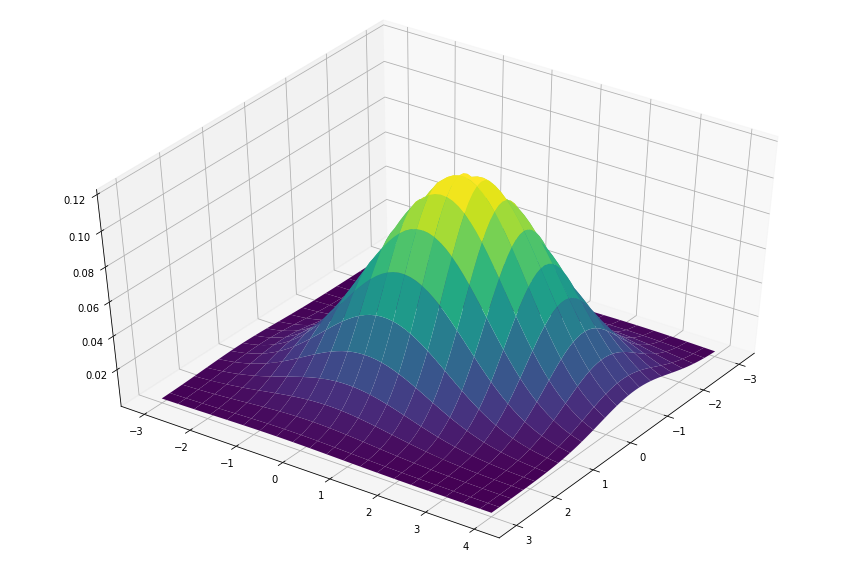

In [27]:
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax.view_init(45,35)
plt.show()

### Attempt to use scipy.optimize.minimise to vary mu and Sigma parameters to minimise MAE between observations and bivariate Gaussian regression plane (think about quantile regression component next...)

In [28]:
# Pack the (X) time of day and (Y) days since winter solstice variables into a single 3D array
X = PV_2017_15M.time_of_day.values.reshape(96,365)
Y = PV_2017_15M.days_since_winter_solstice.values.reshape(96,365)
Z = PV_2017_15M.GHI.values.reshape(96,365)

dim = (96, 365)
pos = np.empty(dim + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [29]:
# Do X & Y need to be transformed so the middle of the day/summer solstice is zero since the normal distribution is
# centred on zero?

In [30]:
def create_Z_hat(params):
    mu_X = params[0]
    mu_Y = params[1]
    mu = np.array([mu_X, mu_Y])
    
    sigma_1 = params[2]
    sigma_2 = params[3]
    sigma_3 = params[4]
    sigma_4 = params[5]
    
    Sigma = np.array([[sigma_1 , sigma_2], [sigma_3,  sigma_4]])
    
    F_hat = multivariate_normal(mu, Sigma)
    Z_hat = F_hat.pdf(pos) 
    
    return Z_hat

In [31]:
def objective(params):
    return np.nansum(np.absolute(create_Z_hat(params) - Z))

In [32]:
def isPSD(params, tol=1e-8):
  E,V = scipy.linalg.eigvalsh(np.matrix(params[2:]).reshape(2,2))
  return np.all(E > -tol)

In [33]:
np.matrix(params[2:]).reshape(2,2)

NameError: name 'params' is not defined

In [ ]:
isPSD(params)

In [ ]:
params = [-2.7,1.,1.,15,-.5,2.]

In [ ]:
solution = minimize(objective,x0,method='COBYLA')

In [ ]:
solution

In [ ]:
solution.x

### Overlay regression plane with observed data

In [ ]:
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax.view_init(45,35)
plt.show()

### Build quantile regression model predicting GHI from the number of minutes after the start of the day - based on __[the examples in the documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)__

In [ ]:
quantiles = np.arange(0.6,1,.025)

def fit_model(q):
    mod = smf.quantreg('mean_dir_horiz ~ time_of_day + days_since_winter_solstice', PV_2017)
    res = mod.fit(q=q, kernel='gau')
    return [q, res.params['Intercept'], res.params['time_of_day']] + \
           res.conf_int().loc['time_of_day'].tolist()

models = [fit_model(y) for y in quantiles]
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])


In [ ]:
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])
models

In [ ]:
mod = smf.quantreg('mean_dir_horiz ~ time_of_day + days_since_winter_solstice', PV_2017)

In [ ]:
res = mod.fit(q=0.85, kernel='gau')

In [ ]:
res.summary()

This does not appear to be fitting a normal distribution to the data.

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
curve_fit.

The headings for the output parameters are based on a linear regression. What do these represent and how can they be translated back into a normal distribution?